In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from plotly import graph_objects as go, express as pex
from scipy import integrate, interpolate as interp, signal as sig
from jupyterthemes import jtplot

In [2]:
jtplot.reset()
plt.style.use("seaborn")
plt.rcParams["axes.axisbelow"] = True
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["figure.figsize"] = (16/2, 9/2)
plt.rcParams["figure.dpi"] = 100
plt.rcParams["text.latex.preamble"] = [r"\usepackage{physics}", r"\usepackage{url}"]

In [193]:
class ColorDifference:
    
    def __init__(self, light1, light2, reflectance, observer, light1_name=None, light2_name=None):
        if type(light1) == str:
            self.light1_wavelength, self.light1_intensity = np.genfromtxt(light1,
                                                                          delimiter=',',
                                                                          unpack=True)
        elif type(light1) in [list, np.ndarray]:
            self.light1_wavelength, self.light1_intensity = light1
        else:
            raise NotImplementedError
            
        if type(light2) == str:
            self.light2_wavelength, self.light2_intensity = np.genfromtxt(light2,
                                                                          delimiter=',',
                                                                          unpack=True)
        elif type(light2) in [list, np.ndarray]:
            self.light2_wavelength, self.light2_intensity = light2
        else:
            raise NotImplementedError
            
        if type(reflectance) == str:
            self.refl_wavelength, self.refl_intensity = np.genfromtxt(reflectance,
                                                                        delimiter=',',
                                                                        unpack=True)
        elif type(light) in [list, np.ndarray]:
            self.refl_wavelength, self.refl_intensity = reflectance
        else:
            raise NotImplementedError
            
        if type(observer) == str:
            self.obs_wavelength, self.xbar, self.ybar, self.zbar = np.genfromtxt(observer,
                                                                                 delimiter=',',
                                                                                 unpack=True)
        elif type(light) in [list, np.ndarray]:
            self.obs_wavelength, self.xbar, self.ybar, self.zbar = observer
        else:
            raise NotImplementedError
            
        self.light1_intensity /= self.light1_intensity.max()
        self.light2_intensity /= self.light2_intensity.max()
        self.light1_name = light1_name
        self.light2_name = light2_name
            
    def spec2XYZ(self, wavelength, spectrum, observer):
        XYZ = []
        for i in range(len(observer)):
            integrand = spectrum*observer[i]
            integral = integrate.trapz(integrand, wavelength)
            XYZ.append(integral)
        X, Y, Z = XYZ
        return X, Y, Z
    
    def equalizeLengths(self):
        overall_wlmin = max(self.light1_wavelength.min(), self.light2_wavelength.min(),
                            self.refl_wavelength.min(), self.obs_wavelength.min())
        overall_wlmax = min(self.light2_wavelength.max(), self.light2_wavelength.max(),
                            self.refl_wavelength.max(), self.obs_wavelength.max())
        overall_wllen = max(self.light1_wavelength.size, self.light2_wavelength.size,
                            self.refl_wavelength.size, self.obs_wavelength.size)

        xbar_interp = interp.interp1d(self.obs_wavelength, self.xbar)
        ybar_interp = interp.interp1d(self.obs_wavelength, self.ybar)
        zbar_interp = interp.interp1d(self.obs_wavelength, self.zbar)
        light1_interp = interp.interp1d(self.light1_wavelength, self.light1_intensity)
        light2_interp = interp.interp1d(self.light2_wavelength, self.light2_intensity)
        refl_interp = interp.interp1d(self.refl_wavelength, self.refl_intensity)

        self.wavelength = np.linspace(overall_wlmin, overall_wlmax, overall_wllen)
        
        self.xbar0 = self.xbar.copy()
        self.ybar0 = self.ybar.copy()
        self.zbar0 = self.zbar.copy()
        
        self.xbar = xbar_interp(self.wavelength)
        self.ybar = ybar_interp(self.wavelength)
        self.zbar = zbar_interp(self.wavelength)
        self.light1 = light1_interp(self.wavelength)
        self.light2 = light2_interp(self.wavelength)
        self.reflectance = refl_interp(self.wavelength)
        
    def displaySpectra(self):
        plt.figure()
        plt.plot(self.wavelength, self.light1,
                 self.wavelength, self.light2)
        plt.title('illuminant')
        if self.light1_name is not None:
            plt.legend([self.light1_name, self.light2_name])
        plt.xlabel('wavelength, nm')
        plt.ylabel('rel. intensity')
        plt.xlim(self.wavelength.min(), self.wavelength.max())
        plt.show()
        
        plt.figure()
        plt.plot(self.wavelength, self.reflectance)
        plt.title('object reflectance')
        plt.xlabel('wavelength, nm')
        plt.ylabel('rel. intensity')
        plt.xlim(self.wavelength.min(), self.wavelength.max())
        plt.show()
        
        plt.figure()
        plt.plot(self.wavelength, self.xbar,
                 self.wavelength, self.ybar,
                 self.wavelength, self.zbar)
        plt.title('standard observer')
        plt.legend([r'$\bar{x}$', r'$\bar{y}$', r'$\bar{z}$'])
        plt.xlabel('wavelength, nm')
        plt.ylabel('rel. intensity')
        plt.xlim(self.wavelength.min(), self.wavelength.max())
        plt.show()
        
    def getLabDifference(self):
        X1n, Y1n, Z1n = 95.04, 100, 108.88
        X2n, Y2n, Z2n = 95.68, 100, 92.14
        delta = 6/29
        
        def f(t):
            if t > delta**3:
                return t**(1/3)
            else:
                return t/(3*delta**2) + 4/29
            
        def l(t):
            if t > delta**3:
                return 116*t - 16
            else:
                return 903.3 * t
        
        P1 = self.light1 * self.reflectance
        P2 = self.light2 * self.reflectance
        X1, Y1, Z1 = self.spec2XYZ(self.wavelength, P1,
                                   [self.xbar, self.ybar, self.zbar])
        X2, Y2, Z2 = self.spec2XYZ(self.wavelength, P2,
                                   [self.xbar, self.ybar, self.zbar])
        
        self.XYZ1 = np.array([X1, Y1, Z1])/Y1.max()
        self.XYZ2 = np.array([X2, Y2, Z2])/Y2.max()
        
        L1 = 116*f(Y1/Y1n) - 16
        a1 = 500 * (f(X1/X1n) - f(Y1/Y1n))
        b1 = 200 * (f(Y1/Y1n) - f(Z1/Z1n))
        L2 = 116*f(Y2/Y2n) - 16
        a2 = 500 * (f(X2/X2n) - f(Y2/Y2n))
        b2 = 200 * (f(Y2/Y2n) - f(Z2/Z2n))
        
        self.Lab1 = [L1, a1, b1]
        self.Lab2 = [L2, a2, b2]
        self.LabDE = np.sqrt((L2 - L1)**2 + (a2 - a1)**2 + (b2 - b1)**2)
        
    def getLChDifference(self):
        L1, a1, b1 = self.Lab1
        L2, a2, b2 = self.Lab2
        
        C1 = np.hypot(a1, b1)
        C2 = np.hypot(a2, b2)
        h1 = np.arctan(b1/a1)
        h2 = np.arctan(b2/a2)
        
        self.LCh1 = [L1, C1, h1]
        self.LCh2 = [L2, C2, h2]
        self.LChDE = np.sqrt((L2 - L1)**2 + (C2 - C1)**2 + (h2 - h1)**2)
    
    def main(self, plot=False):
        self.equalizeLengths()
        if plot:
            self.displaySpectra()
        self.getLabDifference()
        self.getLChDifference()

In [194]:
light1 = np.genfromtxt('d65.csv', delimiter=',', unpack=True)
light2 = np.genfromtxt('d55.csv', delimiter=',', unpack=True)
refl_wl = np.genfromtxt('MacbethColorChecker.csv', delimiter=',',
                    skip_header=1, unpack=True)[0]
obs = np.genfromtxt('CIE1964.csv', delimiter=',', unpack=True)

	 LabDE 	 LChDE
	 ===== 	 =====


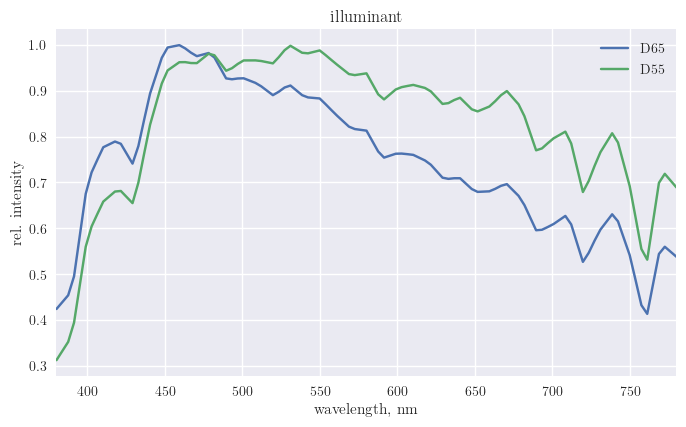

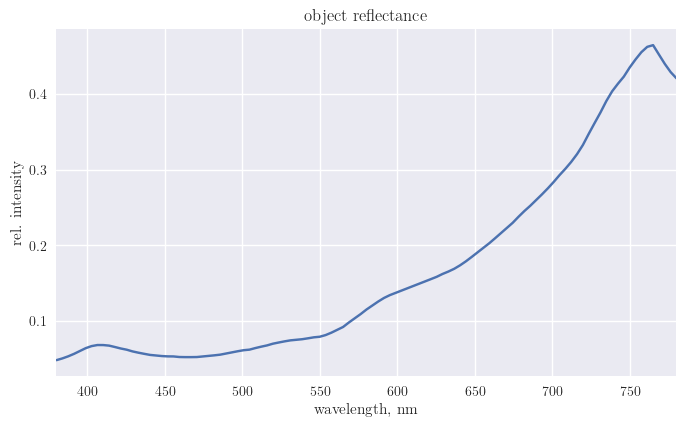

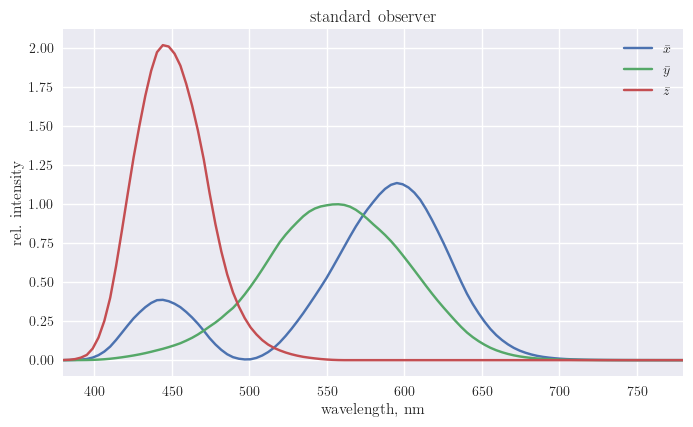

1 	 3.14 	 3.10
2 	 4.43 	 4.16
3 	 2.96 	 2.67
4 	 2.40 	 2.23
5 	 2.77 	 2.65
6 	 3.11 	 2.92
7 	 6.10 	 6.04
8 	 3.76 	 2.51
9 	 5.10 	 5.04
10 	 1.80 	 1.74
11 	 4.22 	 3.60
12 	 6.12 	 5.82
13 	 4.38 	 2.49
14 	 2.58 	 2.56
15 	 5.76 	 5.73
16 	 6.29 	 5.39
17 	 3.79 	 3.54
18 	 4.12 	 4.08
19 	 4.18 	 4.14
20 	 3.62 	 4.43
21 	 3.07 	 3.92
22 	 2.54 	 3.51
23 	 1.94 	 1.98
24 	 1.37 	 1.38


In [198]:
print('\t LabDE \t LChDE')
print('\t ===== \t =====')
for i in range(1, 25):
    refl_int = np.genfromtxt('MacbethColorChecker.csv', delimiter=',',
                    skip_header=1, unpack=True)[i]
    refl = np.array([refl_wl, refl_int])
    spec = ColorDifference(light1, light2, refl, obs, 'D65', 'D55')
    if i == 1:
        spec.main(True)
    else:
        spec.main(False)
    print(i, '\t %.2f'%spec.LabDE, '\t', '%.2f'%spec.LChDE)